In [2]:
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch
from tqdm import tqdm

from dataset import ProteinSmilesDataset
from smiles import AF2SmilesTransformer
from utils import VocSmiles, check_smiles
from trainer import Runner
import os
from torch.utils.data import DataLoader
import time, random
import numpy as np

from rdkit import Chem

## Suppress RDKit warnings
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

dev = torch.device('cuda')
devices = [0]

In [4]:
model_config = {}

trainer = Runner(model_num=360)

## Testing

target_proteins = ['Q96RJ0', 'P21728', 'P35462', 'P08912', 'P47898', 'P07550', 'P14416', 'P11229', 'P08173']
smiles = []
smiles_dict = {}
for protein in target_proteins:
    p_smiles = trainer.targetted_generation(protein_id=protein, batch_size=10, repeat=250)
    smiles_dict[protein] = p_smiles

['_', 'GO', '#', '(', ')', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '8', '=', 'B', 'C', 'EOS', 'F', 'I', 'L', 'N', 'O', 'P', 'R', 'S', '[B-]', '[C-]', '[C@@H]', '[C@@]', '[C@H]', '[C@]', '[N+]', '[N-]', '[N@+]', '[O-]', '[OH+]', '[S+]', '[S@+]', '[S@@+]', '[SH]', '[Si]', '[n+]', '[nH]', '[s+]', '[te]', '\\', 'c', 'n', 'o', 's']
Dataset: len: 484677
Generating SMILES for Q96RJ0
Generating SMILES 250/250

Validating: 2289.0/2500 of generated SMILES are valid.

Generating SMILES for P21728
Generating SMILES 250/250

Validating: 2291.0/2500 of generated SMILES are valid.

Generating SMILES for P35462
Generating SMILES 250/250

Validating: 2297.0/2500 of generated SMILES are valid.

Generating SMILES for P08912
Generating SMILES 250/250

Validating: 2311.0/2500 of generated SMILES are valid.

Generating SMILES for P47898
Generating SMILES 250/250

Validating: 2287.0/2500 of generated SMILES are valid.

Generating SMILES for P07550
Generating SMILES 250/250

Validating: 2303.0/2500 

In [5]:
print(target_proteins)

['Q96RJ0', 'P21728', 'P35462', 'P08912', 'P47898', 'P07550', 'P14416', 'P11229', 'P08173']


In [8]:
## Check VALIDITY

def validate(smiles):
    
    valid = []
    scores = check_smiles(smiles)
    for i, smile in enumerate(smiles):
        if scores[i] == 1:
            valid.append(smile)
    
    return valid


valid = {}

for protein in target_proteins:
    valid[protein] = validate(smiles_dict[protein])

valid_percentages = [len(valid[p])/len(smiles_dict[p]) for p in target_proteins]

print(valid_percentages)      

[0.9156, 0.9164, 0.9188, 0.9244, 0.9148, 0.9212, 0.9156, 0.9252, 0.9268]


In [9]:
## Checking for duplicates (identical SMILES)

non_duplicate = {}
for p in target_proteins:
    smiles_list = valid[p]
    non_dupes = list(set(smiles_list))
    non_duplicate[p] = non_dupes
    print(p, len(smiles_list), len(non_dupes), len(smiles_list) - len(non_dupes))


Q96RJ0 2289 2282 7
P21728 2291 2280 11
P35462 2297 2289 8
P08912 2311 2298 13
P47898 2287 2280 7
P07550 2303 2289 14
P14416 2289 2280 9
P11229 2313 2310 3
P08173 2317 2308 9


In [10]:
## Canonize to check how many of the generated molecules are unique

non_duplicate_canonized = {}
for p in target_proteins:
    smiles_list = non_duplicate[p]
    canonized = [Chem.CanonSmiles(smile) for smile in smiles_list]
    canonized_non_dupes = list(set(canonized))
    non_duplicate_canonized[p] = canonized_non_dupes
    print(p, len(smiles_list), len(canonized_non_dupes), len(smiles_list) - len(canonized_non_dupes))
    
n_canonized_non_dupes = [len(non_duplicate_canonized[p]) for p in target_proteins]

Q96RJ0 2282 2281 1
P21728 2280 2279 1
P35462 2289 2289 0
P08912 2298 2298 0
P47898 2280 2279 1
P07550 2289 2289 0
P14416 2280 2280 0
P11229 2310 2310 0
P08173 2308 2307 1


In [11]:
## Load the dataset
from trainer import load_dataset, load_voc
from config import DatasetConfig

config = DatasetConfig()
voc = load_voc(config)

dataset = load_dataset(voc, config)

['_', 'GO', '#', '(', ')', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '8', '=', 'B', 'C', 'EOS', 'F', 'I', 'L', 'N', 'O', 'P', 'R', 'S', '[B-]', '[C-]', '[C@@H]', '[C@@]', '[C@H]', '[C@]', '[N+]', '[N-]', '[N@+]', '[O-]', '[OH+]', '[S+]', '[S@+]', '[S@@+]', '[SH]', '[Si]', '[n+]', '[nH]', '[s+]', '[te]', '\\', 'c', 'n', 'o', 's']
Dataset: len: 484677


In [12]:
# Isolate smiles based on protein id

from utils import standardize_mol

protein_smiles_dict = {}
all_smiles = []
for line in dataset.tsv_dataset:
    pid, pchembl, smiles = line.split('\t')
    tokens = smiles.split(' ')[:-1]
    joined = ''.join(tokens)

    if protein_smiles_dict.get(pid) is not None:
        protein_smiles_dict[pid] += [joined]
    else:
        protein_smiles_dict[pid] = [joined]
        
    all_smiles += [joined]

all_smiles = list(set(all_smiles))

all_smiles_canonized = []
for smile in all_smiles:
    res = check_smiles([smile])
    if res[0][0] != 0:
        canonized = Chem.CanonSmiles(smile)
        all_smiles_canonized += [canonized]
        
        
print(len(all_smiles), len(all_smiles_canonized))

76493 56823


In [14]:
## Check whether generated smiles overlap with the dataset

all_set = set(all_smiles_canonized)
differences = []

for i, protein in enumerate(target_proteins):
    intersect = set(non_duplicate_canonized[protein]).intersection(all_set)
    difference = set(non_duplicate_canonized[protein]).difference(all_set)
    differences += [len(list(difference))]
    print(protein, 
          len(list(intersect)),
          len(list(difference)))
#           num_datapoints[i])


Q96RJ0 288 1993
P21728 295 1984
P35462 278 2011
P08912 309 1989
P47898 283 1996
P07550 265 2024
P14416 268 2012
P11229 272 2038
P08173 288 2019


In [17]:
## Find average length of generated smiles:
mean_l = []
max_l = []
min_l = []

for p in target_proteins:
    lengths = [len(smile) for smile in non_duplicate_canonized[p]]
    mean = np.mean(lengths)
    min_l += [min(lengths)]
    max_l += [max(lengths)]
    mean_l += [mean]
    print(p, mean)

print(target_proteins)
## Find the number of datapoints per protein

data_mean_l = []

for p in target_proteins:
    lengths = [len(smile) for smile in protein_smiles_dict[p]]
    mean = np.mean(lengths)
    data_mean_l += [mean]

num_datapoints = [len(protein_smiles_dict[p]) for p in target_proteins]

print(target_proteins)
# print(protein_smiles_dict[target_proteins[0]])


Q96RJ0 31.366505918456816
P21728 31.2141290039491
P35462 32.02359108781127
P08912 31.279808529155787
P47898 31.296621325142606
P07550 31.67584097859327
P14416 32.55833333333333
P11229 31.445454545454545
P08173 31.465106198526225
['Q96RJ0', 'P21728', 'P35462', 'P08912', 'P47898', 'P07550', 'P14416', 'P11229', 'P08173']
['Q96RJ0', 'P21728', 'P35462', 'P08912', 'P47898', 'P07550', 'P14416', 'P11229', 'P08173']


In [18]:
from alphafold.papyrus import *

folder = '/media/andrius/Extreme SSD/datasets/foldedPapyrus/proteins'
proteins = [load_protein_sequence(pid, folder) for pid in target_proteins]
headers = [p.info for p in proteins]
names = [h.split('|')[2].split('OS')[0] for h in headers]
print(names)

['TAAR1_HUMAN Trace amine-associated receptor 1 ', 'DRD1_HUMAN D(1A) dopamine receptor ', 'DRD3_HUMAN D(3) dopamine receptor ', 'ACM5_HUMAN Muscarinic acetylcholine receptor M5 ', '5HT5A_HUMAN 5-hydroxytryptamine receptor 5A ', 'ADRB2_HUMAN Beta-2 adrenergic receptor ', 'DRD2_HUMAN D(2) dopamine receptor ', 'ACM1_HUMAN Muscarinic acetylcholine receptor M1 ', 'ACM4_HUMAN Muscarinic acetylcholine receptor M4 ']


['Q96RJ0', 'P21728', 'P35462', 'P08912', 'P47898', 'P07550', 'P14416', 'P11229', 'P08173']


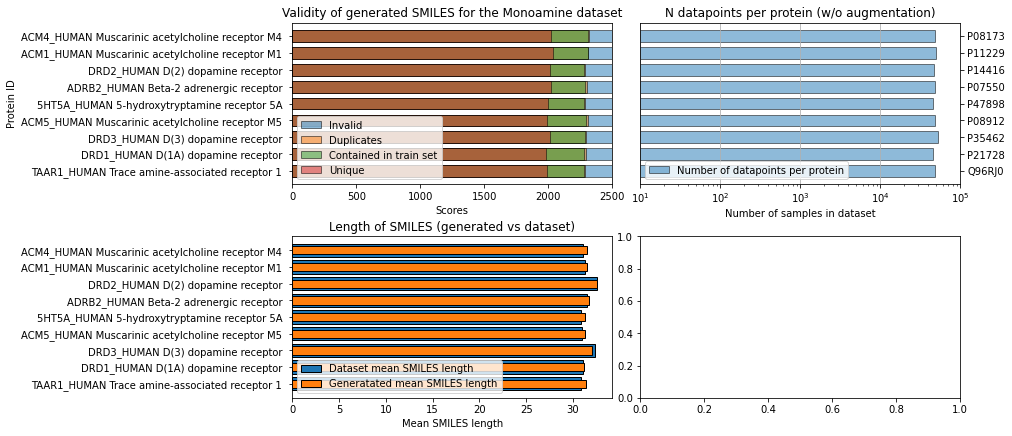

In [22]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,6)

fig, [[ax, ax2], [ax3, ax4]] = plt.subplots(2, 2)
labels = target_proteins
width = 0.7
alpha = 0.5

# print(len(list(difference)), len(valid_percentages))
# print(valid_percentages[0], n_canonized_non_dupes[0], differences[0])
valid = [v * 2500 for v in valid_percentages]
total = [2500 for _ in range(len(valid))]

## 1 ##
ax.barh(names, total, width, label='Invalid', alpha=alpha, edgecolor='k')
ax.barh(names, valid, width, label='Duplicates', alpha=alpha, edgecolor='k')
ax.barh(names, n_canonized_non_dupes, width, label='Contained in train set', alpha=alpha, edgecolor='k')
ax.barh(names, differences, width, label='Unique', alpha=alpha, edgecolor='k')
ax.set_xlabel('Scores')
ax.set_ylabel('Protein ID')
ax.set_xlim(0, 2500)
ax.set_title('Validity of generated SMILES for the Monoamine dataset')
ax.legend(loc='lower left')

## 2 ##
ax2.barh(labels, num_datapoints, width, label='Number of datapoints per protein', alpha=0.5, edgecolor='k')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xlabel('Number of samples in dataset')
ax2.set_xscale('log')
ax2.set_xlim(10e0, 10e4)
ax2.grid(axis='x')
ax2.set_title('N datapoints per protein (w/o augmentation)')
ax2.legend(loc='lower left')

## 3 ##
ax3.barh(names, data_mean_l, 0.8, label='Dataset mean SMILES length', alpha=1, edgecolor='k')
ax3.barh(names, mean_l, width-0.2, label='Generatated mean SMILES length', alpha=1, edgecolor='k')

ax3.set_xlabel('Mean SMILES length')
ax3.set_title('Length of SMILES (generated vs dataset)')
ax3.legend(loc='lower left')


print(labels)
fig.tight_layout(pad=0.5)
plt.show()


top_targets = ['Q96RJ0', 'P21728', 'P35462', 'P08912', 'P47898', 'P07550', 'P14416', 'P11229', 'P08173']

In [236]:
print(proteins[0].info)
print(proteins[0].seq)

>sp|P21917|DRD4_HUMAN D(4) dopamine receptor OS=Homo sapiens OX=9606 GN=DRD4 PE=1 SV=3

MGNRSTADADGLLAGRGPAAGASAGASAGLAGQGAAALVGGVLLIGAVLAGNSLVCVSVATERALQTPTNSFIVSLAAADLLLALLVLPLFVYSEVQGGAWLLSPRLCDALMAMDVMLCTASIFNLCAISVDRFVAVAVPLRYNRQGGSRRQLLLIGATWLLSAAVAAPVLCGLNDVRGRDPAVCRLEDRDYVVYSSVCSFFLPCPLMLLLYWATFRGLQRWEVARRAKLHGRAPRRPSGPGPPSPTPPAPRLPQDPCGPDCAPPAPGLPRGPCGPDCAPAAPSLPQDPCGPDCAPPAPGLPPDPCGSNCAPPDAVRAAALPPQTPPQTRRRRRAKITGRERKAMRVLPVVVGAFLLCWTPFFVVHITQALCPACSVPPRLVSAVTWLGYVNSALNPVIYTVFNAEFRNVFRKALRACC
